In [1]:
import random
import numpy as np

# 设置 Python 内置 random 库的全局随机种子
random.seed(24)

# 设置 Numpy 库的全局随机种子
np.random.seed(24)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler

# 特征筛选

## 特征筛选函数封装

### 基于RSF的特征重要性

In [5]:
#基于RSF特征重要性

import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

def rsf_feature_importances(rsf, X, y):
    rsf.fit(X, y)
    r = permutation_importance(rsf, X, y, n_repeats=30, random_state=24)
    return r.importances_mean

def select_features_survival_analysis(data, n_features_to_select=5):
    # Separate features and target variables
    X = data.drop(columns=['time', 'event'])
    y_df = data[['time', 'event']]
    
    # Convert target variable DataFrame to structured array
    y = Surv.from_dataframe('event', 'time', y_df)
    
    # Initialize Random Survival Forest model
    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=24)

    # 获取特征重要性并排序
    feature_importances = rsf_feature_importances(rsf, X, y)
    important_indices = np.where(feature_importances > 0)[0]  # 筛选出重要性大于0的特征索引
    sorted_indices = important_indices[feature_importances[important_indices].argsort()[::-1]]  # 从高到低排序特征索引

    # 基于重要性大于0的特征数量，选择特征
    if len(sorted_indices) >= 10:
        selected_features = X.columns[sorted_indices][:10].tolist()  # 选择前10个特征
    elif len(sorted_indices) >= 5:
        selected_features = X.columns[sorted_indices][:5].tolist()   # 选择前5个特征
    else:
        selected_features = X.columns[sorted_indices].tolist()       # 选择所有重要性大于0的特征

    return selected_features  # 以列表形式返回选择的特征

### 梯度提升筛选

In [6]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
import pandas as pd

def gradient_boosting_feature_selection(data):
    # 检查数据是否包含`time`和`event`列
    if 'time' not in data.columns or 'event' not in data.columns:
        raise ValueError("Input DataFrame must contain 'time' and 'event' columns.")
    
    # 分离特征和目标变量
    X = data.drop(columns=['time', 'event'])
    y_df = data[['time', 'event']]
    
    # 将目标变量DataFrame转换为结构化数组
    y = Surv.from_dataframe('event', 'time', y_df)
    
    # 初始化梯度提升生存分析模型
    gb_model = GradientBoostingSurvivalAnalysis(loss='squared',random_state=24)

    # 训练模型
    gb_model.fit(X, y)

    # 获取特征重要性并排序
    feature_importances = gb_model.feature_importances_
    important_indices = np.where(feature_importances > 0)[0]  # 筛选出重要性大于0的特征索引
    sorted_indices = important_indices[feature_importances[important_indices].argsort()[::-1]]  # 从高到低排序特征索引

    # 基于重要性大于0的特征数量，选择特征
    if len(sorted_indices) >= 10:
        selected_features = X.columns[sorted_indices][:10].tolist()  # 选择前10个特征
    elif len(sorted_indices) >= 5:
        selected_features = X.columns[sorted_indices][:5].tolist()   # 选择前5个特征
    else:
        selected_features = X.columns[sorted_indices].tolist()       # 选择所有重要性大于0的特征

    return selected_features  # 以列表形式返回选择的特征

### 逐步前向选择CI

In [7]:
#使用随机生存树作为基础模型

from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest

def calculate_ci_for_feature_set(X, y, rsf, features):
    temp_X = X[features].to_numpy()
    rsf.fit(temp_X, y)
    ci = concordance_index_censored(y['event'], y['time'], rsf.predict(temp_X))[0]
    return ci

def stepwise_ci_selection_rsf(data):
    y = data[['event', 'time']].to_records(index=False)
    X = data.drop(columns=['time', 'event'])
    
    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=24)
    
    selected_features = list(X.columns)
    best_ci = 0
    forward_selected_features = []
    ci_changes = []

    while selected_features:
        ci_with_features = []

        for feature in selected_features:
            temp_features = forward_selected_features + [feature]
            ci = calculate_ci_for_feature_set(X, y, rsf, temp_features)
            ci_with_features.append((ci, feature))

        ci_with_features.sort(key=lambda x: x[0], reverse=True)
        best_ci_current, best_feature = ci_with_features[0]

        if best_ci_current > best_ci:
            best_ci = best_ci_current
            forward_selected_features.append(best_feature)
            selected_features.remove(best_feature)
            ci_changes.append((best_ci, best_feature))
        else:
            break

#     return selected_features
    return forward_selected_features

## 五折特征筛选

In [9]:
# 指定未经过smote的五折pkl文件的保存路径
save_path0 = "./未经过smote的五折pkl文件"

In [10]:
import os
import time
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def process_fold(fold_number):
    """处理单个折，执行三种特征选择方法并取交集"""
    train_file_path = os.path.join(save_path0, f'train_fold_{fold_number}.pkl')#主要不同的地方是此处特征筛选所使用的文件不同，使用的是没有经过SMOTE的文件
    fold_start_time = time.time()

    # 加载训练数据
    with open(train_file_path, 'rb') as f:
        train_data = pickle.load(f)

    # 执行三种特征选择方法
    features_survival = select_features_survival_analysis(train_data)
    features_gb = gradient_boosting_feature_selection(train_data)
    features_rsf_stepwise = stepwise_ci_selection_rsf(train_data)

    # 求交集
    selected_features = set(features_survival).intersection(features_gb).intersection(features_rsf_stepwise)

    fold_time = time.time() - fold_start_time
    return fold_number, selected_features, fold_time


if __name__ == '__main__':
    features_per_fold = []
    fold_times = []
    total_start_time = time.time()

    print("开始多进程特征选择...")

    # 启动多进程执行，每折任务一个进程，总共 5 折，最多 15 核
    with ProcessPoolExecutor(max_workers=15) as executor:
        futures = {executor.submit(process_fold, i): i for i in range(1, 6)}

        # 使用 tqdm 显示进度条
        for future in tqdm(as_completed(futures), total=5, desc="处理进度"):
            fold_number, selected_features, fold_time = future.result()
            features_per_fold.append(selected_features)
            fold_times.append(fold_time)

            print(f"\n第 {fold_number} 折选出的特征: {selected_features}")
            print(f"第 {fold_number} 折特征选择完成，耗时 {fold_time:.2f} 秒。")

    # 所有折选出的特征取交集
    final_selected_features = set.intersection(*features_per_fold)
    final_selected_features = sorted(list(final_selected_features))

    total_time = time.time() - total_start_time
    print(f"\n所有折的特征选择总耗时: {total_time:.2f} 秒。")
    print("基于交集的最终选出的特征:", final_selected_features)

开始多进程特征选择...


处理进度:  20%|██        | 1/5 [27:03<1:48:12, 1623.24s/it]


第 1 折选出的特征: {'Chemotherapy_Received', 'Histology_Squamous_Cell_Carcinoma', 'Primary_Site_Surgery_None', 'Differentiation', 'Radiotherapy_Received', 'Tumor_Stage', 'Age'}
第 1 折特征选择完成，耗时 1623.24 秒。


处理进度:  40%|████      | 2/5 [27:44<34:38, 692.70s/it]   


第 5 折选出的特征: {'Chemotherapy_Received', 'Histology_Squamous_Cell_Carcinoma', 'Differentiation', 'Primary_Site_Surgery_Resection', 'Radiotherapy_Received', 'Tumor_Stage', 'Age'}
第 5 折特征选择完成，耗时 1664.56 秒。


处理进度:  60%|██████    | 3/5 [28:08<12:54, 387.36s/it]


第 3 折选出的特征: {'Chemotherapy_Received', 'Histology_Squamous_Cell_Carcinoma', 'Primary_Site_Surgery_None', 'Differentiation', 'Radiotherapy_Received', 'Tumor_Stage', 'Age'}
第 3 折特征选择完成，耗时 1688.57 秒。


处理进度:  80%|████████  | 4/5 [28:21<03:59, 239.72s/it]


第 2 折选出的特征: {'Lymph_Node_Surgery_Extent_Removed', 'Chemotherapy_Received', 'Primary_Site_Surgery_None', 'Differentiation', 'Radiotherapy_Received', 'Tumor_Stage', 'Age'}
第 2 折特征选择完成，耗时 1701.95 秒。


处理进度: 100%|██████████| 5/5 [28:34<00:00, 342.90s/it]


第 4 折选出的特征: {'Lymph_Node_Surgery_Extent_Removed', 'Chemotherapy_Received', 'Histology_Squamous_Cell_Carcinoma', 'Primary_Site_Surgery_None', 'Differentiation', 'Radiotherapy_Received', 'Tumor_Stage', 'Age'}
第 4 折特征选择完成，耗时 1714.49 秒。

所有折的特征选择总耗时: 1714.71 秒。
基于交集的最终选出的特征: ['Age', 'Chemotherapy_Received', 'Differentiation', 'Radiotherapy_Received', 'Tumor_Stage']


基于交集的最终选出的特征: ['Chemotherapy_Received', 'Tumor_Stage', 'Radiotherapy_Received', 'Primary_Site_Surgery_Resection', 'Histology_Squamous_Cell_Carcinoma', 'Age']


# 模型训练

In [ ]:
# final_selected_features=['Histology_Squamous_Cell_Carcinoma',
#  'Radiotherapy_Received',
#  'Tumor_Stage',
#  'Chemotherapy_Received',
#  'Primary_Site_Surgery_Resection',
#  'Age']

In [11]:
# 更新数据
FS1=final_selected_features
FS1

['Age',
 'Chemotherapy_Received',
 'Differentiation',
 'Radiotherapy_Received',
 'Tumor_Stage']

## 交集训练

In [12]:
save_path0

'./未经过smote的五折pkl文件'

In [13]:
import os
import numpy as np
import pandas as pd
import pickle
from lifelines import CoxTimeVaryingFitter, CoxPHFitter
from lifelines.utils import to_episodic_format
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score
from tqdm import tqdm
import time

start = time.time()


# 自定义函数检查并处理缺失值
def check_and_clean_data(data, required_columns):
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
    missing_count = data[required_columns].isnull().sum().sum()
    if missing_count > 0:
        print(f"Warning: Detected {missing_count} missing values. Dropping affected rows.")
        data = data.dropna(subset=required_columns)
    return data

#自定义函数求CoxTV模型的生存概率
def calculate_survival_probabilities_coxtv(risk_scores, base_hazard, times):
    """
    根据 CoxTimeVaryingFitter 的风险分数和基准风险计算生存概率。
    将生存概率矩阵限制为指定的时间点。
    """
    # 对基准累积风险进行插值，确保与 times 对齐
    base_hazard_interp = np.interp(times, np.arange(len(base_hazard)), base_hazard)
    
    survival_probs = []
    for score in risk_scores:
        # 使用插值后的基准累积风险计算生存概率
        S_t = np.exp(-base_hazard_interp * np.exp(score))
        survival_probs.append(S_t)
    return np.array(survival_probs)



# 初始化模型
CoxTV = CoxTimeVaryingFitter()
CoxPH = CoxPHFitter()
ST = SurvivalTree(random_state=24)
RSF = RandomSurvivalForest(random_state=24)
GBSA = GradientBoostingSurvivalAnalysis(random_state=24)



# 初始化列表用于保存每一折的 CI 和 IBS 评分
c_scores1=[]
brier_scores1=[]


# 模型保存路径
models_save_path = "./5_fold models_without_smote"


# 遍历每一折
for fold_number in tqdm(range(1, 6), desc="Processing folds"):
    # 加载训练集和测试集
    train_file_path = os.path.join(save_path0, f'train_fold_{fold_number}.pkl')
    test_file_path = os.path.join(save_path0, f'test_fold_{fold_number}.pkl')
    with open(train_file_path, 'rb') as f:
        train_data = pickle.load(f)

    with open(test_file_path, 'rb') as f:
        test_data = pickle.load(f)     

    # 提取特征和目标变量
    X_train = train_data[FS1]
    y_train_event = train_data['event'].astype(bool)
    y_train_time = train_data['time']

    X_test = test_data[FS1]
    y_test_event = test_data['event'].astype(bool)
    y_test_time = test_data['time']

    y_train = np.array(list(zip(y_train_event, y_train_time)),
                       dtype=[('event', bool), ('time', float)])
    y_test = np.array(list(zip(y_test_event, y_test_time)),
                      dtype=[('event', bool), ('time', float)])

    # 合并数据（供 CoxPHFitter 使用）
    train_combined = pd.concat([train_data[['time', 'event']], X_train], axis=1)
    test_combined = pd.concat([test_data[['time', 'event']], X_test], axis=1)  


    # 转换为 episodic format（供 CoxTV 使用）
    # 检查并清理数据
    required_columns = ['time', 'event']
    train_data = check_and_clean_data(train_data, required_columns)
    test_data = check_and_clean_data(test_data, required_columns)

    # 检查并添加唯一的 ID 列
    if 'id' not in train_data.columns:
        train_data['id'] = np.arange(len(train_data))
    if 'id' not in test_data.columns:
        test_data['id'] = np.arange(len(test_data))    
    
    episodic_train = to_episodic_format(
        pd.concat([train_data[['time', 'event', 'id']], X_train], axis=1),
        duration_col="time", event_col="event", id_col="id"
    )
    episodic_test = to_episodic_format(
        pd.concat([test_data[['time', 'event', 'id']], X_test], axis=1),
        duration_col="time", event_col="event", id_col="id"
    )

 

    # 训练模型
    CoxPH.fit(train_combined, duration_col='time', event_col='event')   
    CoxTV.fit(episodic_train, id_col='id', start_col='start', stop_col='stop', event_col='event')
    ST.fit(X_train, y_train)
    RSF.fit(X_train, y_train)
    GBSA.fit(X_train, y_train)
    
 

    # 保存模型
    dataset_name = 'FS1'
    models = [
        ('CoxPH', CoxPH),
        ('CoxTV',CoxTV),
        ('ST', ST),
        ('RSF', RSF),
        ('GBSA', GBSA)
    ]

    for model_name, model in models:
        model_filename = f"{dataset_name}_{model_name}_fold{fold_number}.pkl"
        model_filepath = os.path.join(models_save_path, model_filename)
        with open(model_filepath, 'wb') as f:
            pickle.dump(model, f)
 


    #预测CoxPH模型的风险分数
    risk_scores_cph = CoxPH.predict_partial_hazard(test_combined)
    
    #预测CoxTV模型的风险分数
    risk_scores_coxtv_raw = CoxTV.predict_partial_hazard(episodic_test)
    episodic_test['partial_hazard'] = risk_scores_coxtv_raw
    aggregated_risk_scores_coxtv = episodic_test.groupby('id')['partial_hazard'].mean()
    risk_scores_coxtv = aggregated_risk_scores_coxtv.values
    
    # 预测其他模型的风险分数
    y_pred_ST = ST.predict(X_test)
    y_pred_RSF = RSF.predict(X_test)
    y_pred_GBSA = GBSA.predict(X_test)  

    # 计算 IPCW CI
    cindex_CoxPH = concordance_index_ipcw(y_train, y_test, risk_scores_cph, tau=59.9)[0]
    cindex_CoxTV = concordance_index_ipcw(y_train, y_test, risk_scores_coxtv, tau=59.9)[0]    
    cindex_ST = concordance_index_ipcw(y_train, y_test, y_pred_ST, tau=59.9)[0]
    cindex_RSF = concordance_index_ipcw(y_train, y_test, y_pred_RSF, tau=59.9)[0]
    cindex_GBSA = concordance_index_ipcw(y_train, y_test, y_pred_GBSA, tau=59.9)[0]

    
    # 记录 IPCW C-Index 评分
    c_scores1.append({'Model': 'CoxPH', 'Fold': fold_number, 'IPCW C-Index': cindex_CoxPH})   
    c_scores1.append({'Model': 'CoxTV', 'Fold': fold_number, 'IPCW C-Index': cindex_CoxTV})    
    c_scores1.append({'Model': 'ST', 'Fold': fold_number, 'IPCW C-Index': cindex_ST})
    c_scores1.append({'Model': 'RSF', 'Fold': fold_number, 'IPCW C-Index': cindex_RSF})
    c_scores1.append({'Model': 'GBSA', 'Fold': fold_number, 'IPCW C-Index': cindex_GBSA})

    
    
    # 计算 IBS
    ##确定times
    times = np.linspace(10 + 1e-6, 60 - 1e-6, 6)
    
    ##各模型的生存函数
    surv_funcs_CoxPH = CoxPH.predict_survival_function(test_combined, times=times) 
    #CoxTV无法直接计算生存函数，此处是通过自定义函数间接计算的
    surv_funcs_ST = ST.predict_survival_function(X_test)
    surv_funcs_RSF = RSF.predict_survival_function(X_test)
    surv_funcs_GBSA = GBSA.predict_survival_function(X_test)
    
    # 将生存函数转换为在特定时间点的概率估计 
    preds_CoxPH = surv_funcs_CoxPH.values.T
    preds_CoxTV = calculate_survival_probabilities_coxtv(risk_scores_coxtv, CoxTV.baseline_cumulative_hazard_.values.flatten(), times)    
    preds_ST= np.array([fn(times) for fn in surv_funcs_ST])
    preds_RSF= np.array([fn(times) for fn in surv_funcs_RSF])    
    preds_GBSA= np.array([fn(times) for fn in surv_funcs_GBSA])     
    
    #计算IBS分数
    ibs_CoxPH = integrated_brier_score(y_train, y_test, preds_CoxPH, times)
    ibs_CoxTV = integrated_brier_score(y_train, y_test, preds_CoxTV, times)    
    ibs_ST = integrated_brier_score(y_train, y_test, preds_ST, times)
    ibs_RSF = integrated_brier_score(y_train, y_test, preds_RSF, times)
    ibs_GBSA = integrated_brier_score(y_train, y_test, preds_GBSA, times)

    # 记录 IBS 分数
    brier_scores1.append({'Model': 'CoxPH', 'Fold': fold_number, 'IBS': ibs_CoxPH})
    brier_scores1.append({'Model': 'CoxTV', 'Fold': fold_number, 'IBS': ibs_CoxTV})    
    brier_scores1.append({'Model': 'ST', 'Fold': fold_number, 'IBS': ibs_ST})
    brier_scores1.append({'Model': 'RSF', 'Fold': fold_number, 'IBS': ibs_RSF})
    brier_scores1.append({'Model': 'GBSA', 'Fold': fold_number, 'IBS': ibs_GBSA})

    
    
# 计算平均 CI 评分
average_cindex1 = pd.DataFrame(c_scores1).groupby('Model')['IPCW C-Index'].mean().reset_index()

# 计算平均 Brier 分数
average_brier_scores1 = pd.DataFrame(brier_scores1).groupby('Model')['IBS'].mean().reset_index()

# 打印结果
print("Average C-Index:")
print(average_cindex1)
print("Average IBS:")
print(average_brier_scores1)

end = time.time()
print(f"Total time taken: {end - start} seconds")

Processing folds: 100%|██████████| 5/5 [17:21<00:00, 208.35s/it]

Average C-Index:
   Model  IPCW C-Index
0  CoxPH      0.789444
1  CoxTV      0.789444
2   GBSA      0.824279
3    RSF      0.821825
4     ST      0.816774
Average IBS:
   Model       IBS
0  CoxPH  0.123386
1  CoxTV  0.221851
2   GBSA  0.115728
3    RSF  0.116145
4     ST  0.117708
Total time taken: 1041.7610507011414 seconds


## 可视化结果

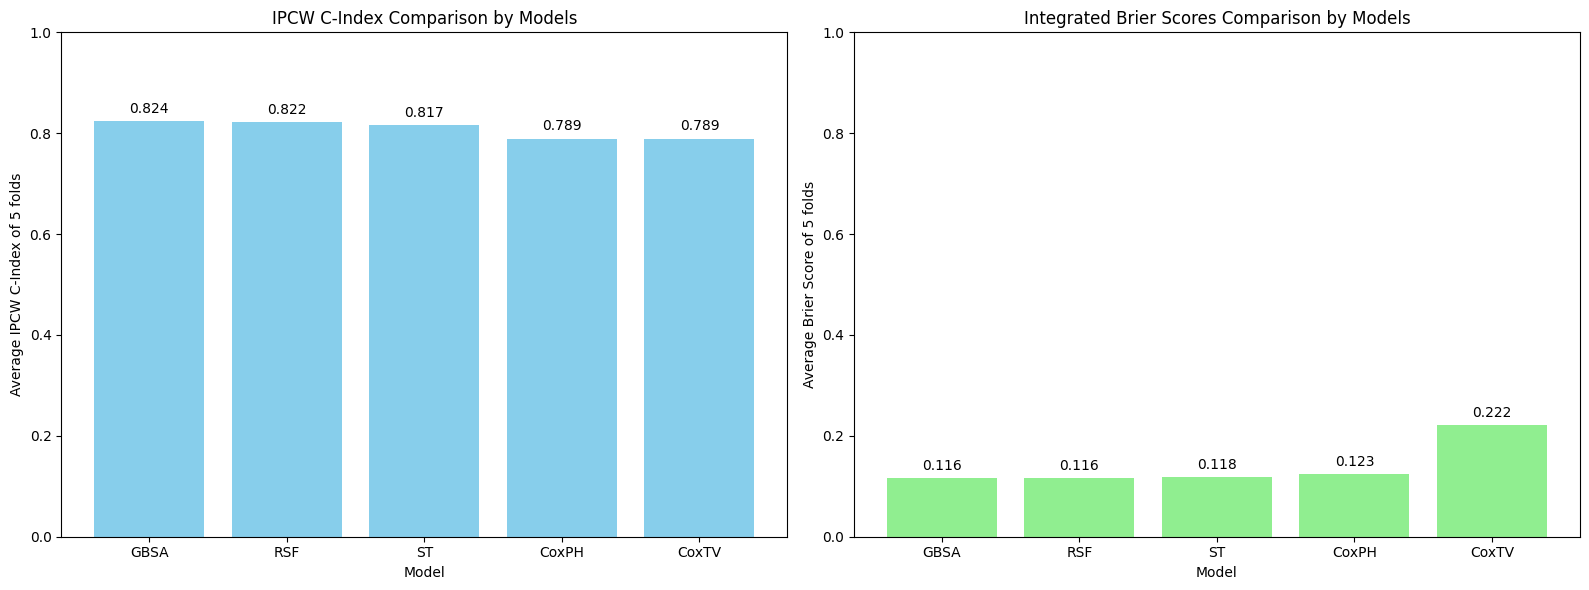

In [14]:
import matplotlib.pyplot as plt

# 对平均C-Index进行降序排序
average_cindex_sorted = average_cindex1.sort_values('IPCW C-Index', ascending=False)

# 对平均Brier分数进行升序排序
average_brier_scores_sorted = average_brier_scores1.sort_values('IBS', ascending=True)

# 创建一个新的figure，尺寸更加平衡
plt.figure(figsize=(16, 6))  # 调整为更加合适的尺寸

# 绘制平均C-Index柱状图
plt.subplot(1, 2, 1)  # 1行2列，当前是第1个图
cindex_bars = plt.bar(average_cindex_sorted['Model'], average_cindex_sorted['IPCW C-Index'], color='skyblue')
plt.title('IPCW C-Index Comparison by Models')
plt.xlabel('Model')
plt.ylabel('Average IPCW C-Index of 5 folds')
plt.ylim(0, 1)  # C-Index 的范围通常是 0 到 1
# 添加数据标签
for bar in cindex_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

# 绘制平均Brier分数柱状图
plt.subplot(1, 2, 2)  # 1行2列，当前是第2个图
brier_bars = plt.bar(average_brier_scores_sorted['Model'], average_brier_scores_sorted['IBS'], color='lightgreen')
plt.title('Integrated Brier Scores Comparison by Models')
plt.xlabel('Model')
plt.ylabel('Average Brier Score of 5 folds')
plt.ylim(0, 1)  # Brier分数的范围通常是 0 到 1
# 添加数据标签
for bar in brier_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

# 显示整个figure的内容
plt.tight_layout()
plt.show()

# 模型评价

In [15]:
#C-index和AUC属于区分度，IBS属于校准度

## Time-dependent Area under the ROC

###  'BaseFeatureSet'

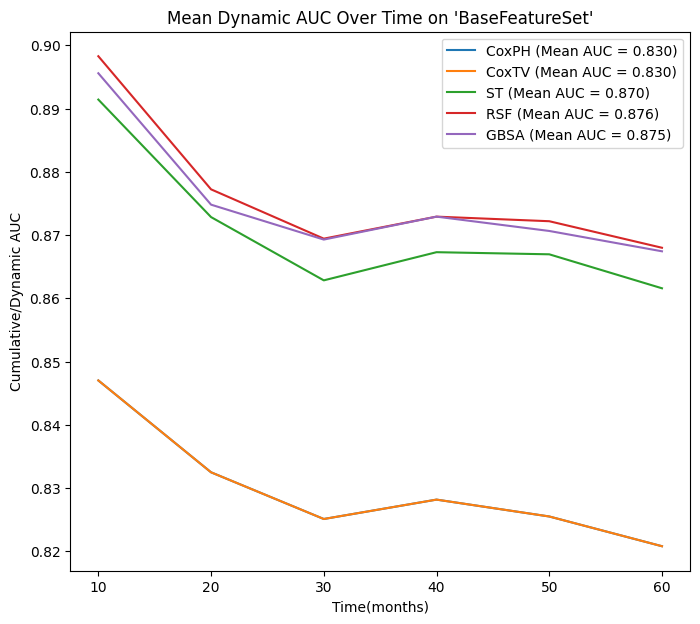

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sksurv.metrics import cumulative_dynamic_auc

# 特征子集
dataset_name = 'FS1'
# 模型名称列表
model_names = ['CoxPH','CoxTV', 'ST', 'RSF', 'GBSA']

# 确定times
times = np.linspace(10 + 1e-6, 60 - 1e-6, 6)

# 初始化存储每个模型的AUCs的字典
aucs = {model_name: [] for model_name in model_names}

# 初始化用于 IPCW 检查的存储
ipcw_support_problems = []

# 遍历每一折
for fold_number in range(1, 6):
    # 加载测试集
    test_file_path = os.path.join(save_path0, f'test_fold_{fold_number}.pkl')
    with open(test_file_path, 'rb') as f:
        test_data = pickle.load(f)

    # 提取特征和目标变量
    X_test = test_data[FS1]
    y_test_event = test_data['event'].astype(bool)
    y_test_time = test_data['time']

    # 将目标变量转换为结构化数组
    y_test = np.array(list(zip(y_test_event, y_test_time)),
                      dtype=[('event', bool), ('time', float)])

    # 加载训练集的生存信息（计算 AUC 需要训练集的信息）
    train_file_path = os.path.join(save_path0, f'train_fold_{fold_number}.pkl')
    with open(train_file_path, 'rb') as f:
        train_data = pickle.load(f)

    y_train_event = train_data['event'].astype(bool)
    y_train_time = train_data['time']

    y_train = np.array(list(zip(y_train_event, y_train_time)),
                       dtype=[('event', bool), ('time', float)])
    
    
    # 合并数据（供 CoxPHFitter 使用）
    test_combined = pd.concat([test_data[['time', 'event']], X_test], axis=1)  


    # 转换为 episodic format（供 CoxTV 使用）
    # 检查并清理数据
    required_columns = ['time', 'event']
    test_data = check_and_clean_data(test_data, required_columns)

    # 检查并添加唯一的 ID 列
    if 'id' not in test_data.columns:
        test_data['id'] = np.arange(len(test_data))    
    
    episodic_test = to_episodic_format(
        pd.concat([test_data[['time', 'event', 'id']], X_test], axis=1),
        duration_col="time", event_col="event", id_col="id"
    )

    # 遍历每个模型
    for model_name in model_names:
        # 加载模型
        model_filename = f"{dataset_name}_{model_name}_fold{fold_number}.pkl"
        model_filepath = os.path.join(models_save_path, model_filename)
        
        with open(model_filepath, 'rb') as f:
            model = pickle.load(f) 
                       
            
        
        # 获取测试集的风险评分
        if model_name == 'CoxPH':
            risk_scores = model.predict_partial_hazard(test_combined)
        elif model_name=='CoxTV':
            risk_scores_coxtv_raw = model.predict_partial_hazard(episodic_test)
            episodic_test['partial_hazard'] = risk_scores_coxtv_raw
            aggregated_risk_scores_coxtv = episodic_test.groupby('id')['partial_hazard'].mean()
            risk_scores= aggregated_risk_scores_coxtv.values   
        else:
            risk_scores = model.predict(X_test)
        
        # 计算 IPCW 权重，如果审查生存函数达到零，则存储
        try:
            auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, times)
            aucs[model_name].append(auc)
        except ValueError as e:
            ipcw_support_problems.append((fold_number, model_name, str(e)))          


# 计算每个模型的平均AUC五折的每个时间点上的平均值
mean_aucs1 = {model_name: np.mean(aucs[model_name], axis=0) for model_name in model_names}

overall_mean_aucs1 = pd.DataFrame({
    'Model': model_name,
    'Average_AUC': np.mean(mean_auc)
} for model_name, mean_auc in mean_aucs1.items())

# 绘制Time-dependent AUC曲线并添加数据标签
plt.figure(figsize=(8, 7))
for model_name, mean_auc in mean_aucs1.items():
    plt.plot(times, mean_auc, label=f'{model_name} (Mean AUC = {np.mean(mean_auc):.3f})')
#     # 添加数据标签
#     for i, auc_value in enumerate(mean_auc):
#         plt.text(times[i], auc_value, f'{auc_value:.3f}', fontsize=9, ha='center', va='bottom')

plt.xlabel('Time(months)')
plt.ylabel('Cumulative/Dynamic AUC')
plt.title("Mean Dynamic AUC Over Time on 'BaseFeatureSet'")
plt.legend(loc="upper right")  # 设置图例位置为右上角
plt.show()

In [17]:
overall_mean_aucs1

,Model,Average_AUC
0,CoxPH,0.829855
1,CoxTV,0.829855
2,ST,0.870488
3,RSF,0.876336
4,GBSA,0.875110


## 合理性分析 KM生存曲线

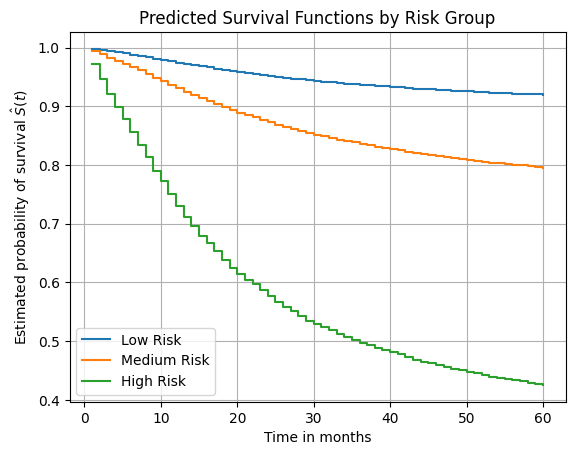

In [18]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv


dataset_name = 'FS1'
model_name = 'GBSA'

# 用于存储每组的生存函数预测
surv_funcs_groups = {0: [], 1: [], 2: []}
time_points = None  # 存储时间点

# 初始化一个空的DataFrame来收集数据
survival_data = pd.DataFrame()

for fold_number in range(1, 6):
    # 加载测试集
    test_file_path = os.path.join(save_path0, f'test_fold_{fold_number}.pkl')
    with open(test_file_path, 'rb') as f:
        test_data = pickle.load(f)
        
    X_test = test_data[FS1]
    y_test_event = test_data['event'].astype(bool)
    y_test_time = test_data['time']
    y_test = Surv.from_arrays(event=y_test_event, time=y_test_time)

    # 加载模型
    model_filename = f"{dataset_name}_{model_name}_fold{fold_number}.pkl"
    model_filepath = os.path.join(models_save_path, model_filename)
    with open(model_filepath, 'rb') as f:
        loaded_model = pickle.load(f)

    # 预测风险分数
    risk_scores = loaded_model.predict(X_test)

    # 确定分组阈值
    threshold_low = np.percentile(risk_scores, 33)
    threshold_high = np.percentile(risk_scores, 66)

    # 根据阈值将样本分组
    groups = np.digitize(risk_scores, [threshold_low, threshold_high])

    # 预测生存函数
    pred_surv_funcs = loaded_model.predict_survival_function(X_test)
    if fold_number == 1:
        time_points = pred_surv_funcs[0].x  # 保存时间点数据

    # 存储每组的生存函数预测
    for i in range(3):
        surv_funcs_groups[i].extend([func.y for func, g in zip(pred_surv_funcs, groups) if g == i])
        
        
    # 将风险分数、生存时间、事件发生与风险组合并为一个DataFrame
    fold_df = pd.DataFrame({
        'time': y_test_time,
        'event': y_test_event,
        'group': groups
    })

    # 将当前折叠的数据添加到总的DataFrame中
    survival_data = pd.concat([survival_data, fold_df], ignore_index=True)

# 计算每组的平均生存函数
average_surv_funcs = {}
for i in range(3):
    average_surv_funcs[i] = np.mean(surv_funcs_groups[i], axis=0)

# 绘制每组的平均生存曲线
plt.figure()
risk_group_labels = ["Low Risk", "Medium Risk", "High Risk"]
for i in range(3):
    plt.step(time_points, average_surv_funcs[i], where="post", label=risk_group_labels[i])

plt.title("Predicted Survival Functions by Risk Group")
plt.ylabel("Estimated probability of survival $\hat{S}(t)$")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from lifelines.statistics import multivariate_logrank_test

# 进行Log-rank检验
results = multivariate_logrank_test(survival_data['time'], survival_data['group'], survival_data['event'], alpha=0.95)

# 设置Pandas显示格式，确保至少显示三位小数
pd.set_option('display.float_format', '{:.4f}'.format)

# 输出检验结果
print(results.summary)

   test_statistic      p  -log2(p)
0       2726.6821 0.0000       inf
